# Importación de módulos generales

In [1]:
%pylab inline
%load_ext memory_profiler

# %pylab

import os
import tempfile
import pandas as pd
# import numpy as np
import networkx as nx
# import matplotlib
# import pylab  as plt
import pygraphviz

from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


# Funciones auxiliares visualización

Importamos las funciones auxiliares para visualizar redes que hemos definido:
- **plot_pomegranate_bn_nx**(pgm, layout=None, node_size=2000, node_color='pink')
- **plot_pomegranate_bn_pgvz**(pgm, filename=None, prog='dot', color='red')
- **plot_pgm_bn**(pgm, layout=None, node_size=2000, node_color='pink'):

In [2]:
from funciones_auxiliares import *

# Lectura de datos

Podemos obtener los datos originales de https://www.kaggle.com/uciml/pima-indians-diabetes-database.

In [3]:
data = pd.read_csv("data/diabetes/prima_indian_diabetes_dataset.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Como podemos observar, hay valores nulos en ciertas variables, en este caso representados mediante el valor 0.

In [4]:
data [['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
print("Valores nulos en cada variable:\n", data.isnull().sum())

print("\nNúmero de registros completos: ", data.dropna().count()[0])

Valores nulos en cada variable:
 Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Número de registros completos:  392


Discretizamos las variables numéricas:

In [5]:
columns_to_discretize = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
num_bins=20

for col in columns_to_discretize:
    data[col] = pd.cut(data[col], bins=num_bins)
    
# data.Glucose = pd.cut(data.Glucose, bins=10)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,"(144.75, 152.5]","(68.1, 73.0]","(34.6, 39.2]",NaN,"(32.87, 35.315]","(0.546, 0.664]","(48.0, 51.0]",1
1,1,"(82.75, 90.5]","(63.2, 68.1]","(25.4, 30.0]",NaN,"(25.535, 27.98]","(0.312, 0.429]","(30.0, 33.0]",0
2,8,"(175.75, 183.5]","(63.2, 68.1]",NaN,NaN,"(23.09, 25.535]","(0.664, 0.781]","(30.0, 33.0]",1
3,1,"(82.75, 90.5]","(63.2, 68.1]","(20.8, 25.4]","(55.6, 97.2]","(27.98, 30.425]","(0.0757, 0.195]","(20.94, 24.0]",0
4,0,"(129.25, 137.0]","(38.7, 43.6]","(34.6, 39.2]","(138.8, 180.4]","(42.65, 45.095]","(2.186, 2.303]","(30.0, 33.0]",1


Y separamos los registros completos(sin valores nulos) de los iniciales

In [6]:
complete_data = data.dropna().reset_index(drop=True)

Dividimos los datos en conjunto de entrenamiento y validación

In [7]:
X = data.drop(columns=['Outcome'])
y = data.Outcome

X_complete = complete_data.drop(columns=['Outcome'])
y_complete = complete_data.Outcome

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3)
X_complete_train, X_complete_test, y_complete_train, y_complete_test = train_test_split(X_complete, y_complete, test_size=1/3)

print("Particiones obtenidas sobre los datos iniciales:")
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test:  ", X_test.shape)
print("y_test:  ", y_test.shape)
print("\nParticiones obtenidas sobre los datos con los registros completos:")
print("X_complete_train: ", X_complete_train.shape)
print("y_complete_train: ", y_complete_train.shape)
print("X_complete_test:  ", X_complete_test.shape)
print("y_complete_test:  ", y_complete_test.shape)

Particiones obtenidas sobre los datos iniciales:
X_train:  (512, 8)
y_train:  (512,)
X_test:   (256, 8)
y_test:   (256,)

Particiones obtenidas sobre los datos con los registros completos:
X_complete_train:  (261, 8)
y_complete_train:  (261,)
X_complete_test:   (131, 8)
y_complete_test:   (131,)


# Algoritmos de búsqueda global

In [8]:
from pgmpy.models import BayesianModel

Definición de scores sobre el dataset:

In [9]:
from pgmpy.estimators import BDeuScore, K2Score, BicScore

bdeu = BDeuScore(complete_data, equivalent_sample_size=5)
k2 = K2Score(complete_data)
bic = BicScore(complete_data)

Si quisieramos usar un algoritmo exacto, tendriamos que iterar sobre los $2^{N(N-1)}$ siendo N el número de nodos, es decir:

In [10]:
N=len(list(complete_data))
print("Número de DAGs posibles con N={} ---> {}".format(N, 2**(N*(N-1))))

Número de DAGs posibles con N=9 ---> 4722366482869645213696


In [11]:
# from pgmpy.estimators import ExhaustiveSearch

# # Definición algoritmos de búsqueda exactos con cada score
# es_bic = ExhaustiveSearch(complete_data, scoring_method=bic)
# es_k2 = ExhaustiveSearch(complete_data, scoring_method=k2)
# es_bdeu = ExhaustiveSearch(complete_data, scoring_method=bdeu)

# # Aprendizaje de las redes
# print("Exhaustive search BIC:")
# %time %memit es_bic_structure = es_bic.estimate()
# print("Exhaustive search K2:")
# %time %memit es_k2_structurel = es_k2.estimate()
# print("Exhaustive search BDeu:")
# %time %memit es_bdeu_structure = es_bdeu.estimate()

Así que vamos a usar Hill Climb Search:

In [12]:
from pgmpy.estimators import HillClimbSearch

hc_bic = HillClimbSearch(data, scoring_method=bic)
hc_k2 = HillClimbSearch(data, scoring_method=k2)
hc_bdeu = HillClimbSearch(data, scoring_method=bdeu)

# Aprendizaje de las redes
print("Hill Climb Search BIC:")
%time %memit hc_bic_structure = hc_bic.estimate()
print("\nHill Climb Search K2:")
%time %memit hc_k2_structure = hc_k2.estimate()
print("\nHill Climb Search BDeu:")
%time %memit hc_bdeu_structure = hc_bdeu.estimate()

Hill Climb Search BIC:
peak memory: 195.05 MiB, increment: 10.16 MiB
Wall time: 28.1 s

Hill Climb Search K2:
peak memory: 220.35 MiB, increment: 25.32 MiB
Wall time: 2min 24s

Hill Climb Search BDeu:
peak memory: 223.14 MiB, increment: 4.33 MiB
Wall time: 32.8 s


Visualizamos los modelos resultantes:

Hill Climb Search BIC:


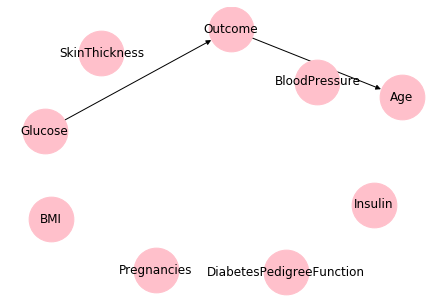

In [13]:
print("Hill Climb Search BIC:")
plot_pgmpy_bn(hc_bic_structure)


Hill Climb Search K2:


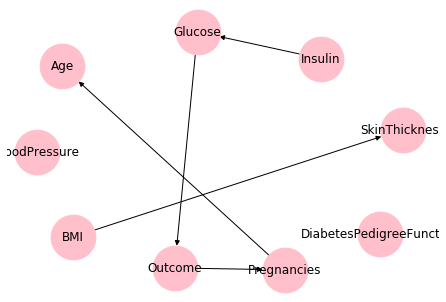

In [14]:
print("\nHill Climb Search K2:")
plot_pgmpy_bn(hc_k2_structure)


Hill Climb Search BDeu:


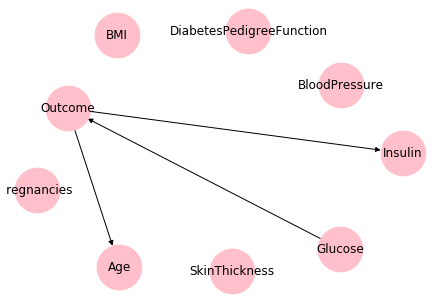

In [15]:
print("\nHill Climb Search BDeu:")
plot_pgmpy_bn(hc_bdeu_structure)

A la hora de estimar, podemos indicar el número máximo de padres por variable. Por ejemplo, si exigimos que sea 1, aprenderemos estructuras de árbol y el aprendizaje será más rápido:

In [16]:
print("Hill Climb Search BIC:")
%time %memit hc_bic_tree = hc_bic.estimate(max_indegree=1)
print("\nHill Climb Search K2:")
%time %memit hc_k2_tree = hc_k2.estimate(max_indegree=1)
print("\nHill Climb Search BDeu:")
%time %memit hc_bdeu_tree = hc_bdeu.estimate(max_indegree=1)

Hill Climb Search BIC:
peak memory: 228.85 MiB, increment: 0.00 MiB
Wall time: 15.8 s

Hill Climb Search K2:
peak memory: 228.85 MiB, increment: 0.00 MiB
Wall time: 20.3 s

Hill Climb Search BDeu:
peak memory: 228.73 MiB, increment: 0.00 MiB
Wall time: 15.5 s


Hill Climb Search BIC tree:


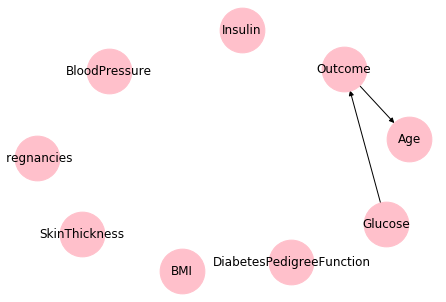

In [17]:
print("Hill Climb Search BIC tree:")
plot_pgmpy_bn(hc_bic_tree)


Hill Climb Search K2 tree:


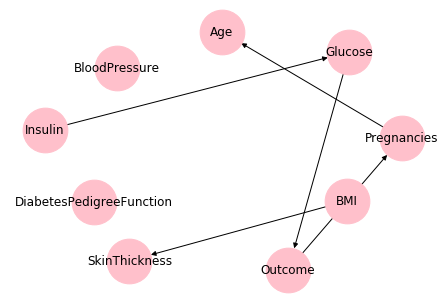

In [18]:
print("\nHill Climb Search K2 tree:")
plot_pgmpy_bn(hc_k2_tree)


Hill Climb Search BDeu tree:


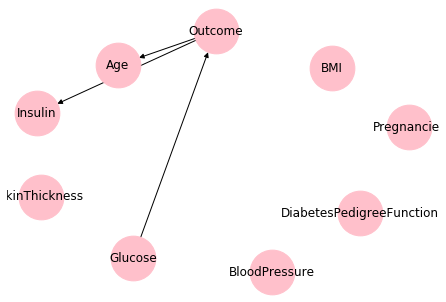

In [19]:
print("\nHill Climb Search BDeu tree:")
plot_pgmpy_bn(hc_bdeu_tree)

# Algoritmos locales mediante tests de independencia

In [20]:
from pgmpy.estimators import ConstraintBasedEstimator

constraint_estimator = ConstraintBasedEstimator(data)

print("Constraint Estimation:")
%time %memit constraint_structure = constraint_estimator.estimate(significance_level=0.01)

Constraint Estimation:


C:\Users\usuario\.conda\envs\PGM\lib\site-packages\pgmpy\estimators\CITests.py:95: UserWarning: Insufficient data for testing Pregnancies _|_ Glucose | []. At least 1520.0 samples recommended, 768 present.
  5 * num_params, len(data)
C:\Users\usuario\.conda\envs\PGM\lib\site-packages\pgmpy\estimators\CITests.py:95: UserWarning: Insufficient data for testing Pregnancies _|_ BloodPressure | []. At least 1520.0 samples recommended, 768 present.
  5 * num_params, len(data)
C:\Users\usuario\.conda\envs\PGM\lib\site-packages\pgmpy\estimators\CITests.py:95: UserWarning: Insufficient data for testing Pregnancies _|_ SkinThickness | []. At least 1040.0 samples recommended, 768 present.
  5 * num_params, len(data)
C:\Users\usuario\.conda\envs\PGM\lib\site-packages\pgmpy\estimators\CITests.py:95: UserWarning: Insufficient data for testing Pregnancies _|_ Insulin | []. At least 1360.0 samples recommended, 768 present.
  5 * num_params, len(data)
C:\Users\usuario\.conda\envs\PGM\lib\site-packages\p

C:\Users\usuario\.conda\envs\PGM\lib\site-packages\pgmpy\estimators\CITests.py:95: UserWarning: Insufficient data for testing DiabetesPedigreeFunction _|_ Age | []. At least 1530.0 samples recommended, 768 present.
  5 * num_params, len(data)
C:\Users\usuario\.conda\envs\PGM\lib\site-packages\pgmpy\estimators\CITests.py:95: UserWarning: Insufficient data for testing Age _|_ Pregnancies | []. At least 1360.0 samples recommended, 768 present.
  5 * num_params, len(data)
C:\Users\usuario\.conda\envs\PGM\lib\site-packages\pgmpy\estimators\CITests.py:95: UserWarning: Insufficient data for testing Age _|_ Glucose | []. At least 1615.0 samples recommended, 768 present.
  5 * num_params, len(data)
C:\Users\usuario\.conda\envs\PGM\lib\site-packages\pgmpy\estimators\CITests.py:95: UserWarning: Insufficient data for testing Age _|_ Insulin | []. At least 1445.0 samples recommended, 768 present.
  5 * num_params, len(data)
C:\Users\usuario\.conda\envs\PGM\lib\site-packages\pgmpy\estimators\CITests

peak memory: 233.59 MiB, increment: 4.83 MiB
Wall time: 2min 35s


Constraint Estimation:


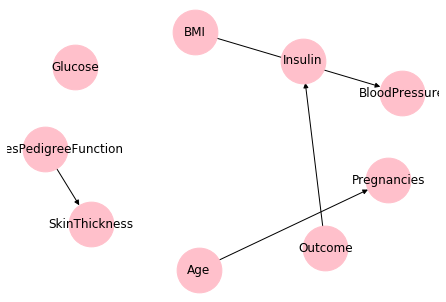

In [21]:
print("Constraint Estimation:")
plot_pgmpy_bn(constraint_structure)

# Aprendizaje de parámetros

Vamos a quedarnos, por ejemplo, con la red aprendida usando *Hill Climb Search* y como score *Bdeu*

In [22]:
from pgmpy.models import BayesianModel

hc_bdeu_model = BayesianModel()
hc_bdeu_model.add_nodes_from(hc_bdeu_structure.nodes)
hc_bdeu_model.add_edges_from(hc_bdeu_structure.edges)

Podemos obtener el recuento de las apariciones de las distintas variables

In [23]:
from pgmpy.estimators import ParameterEstimator

pe = ParameterEstimator(hc_bdeu_model, data)
print(pe.state_counts('Age'))

Outcome          0   1
Age                   
(20.94, 24.0]  119  16
(24.0, 27.0]    51  17
(27.0, 30.0]    27  18
(30.0, 33.0]    12  17
(33.0, 36.0]    11  10
(36.0, 39.0]    13   5
(39.0, 42.0]     9   9
(42.0, 45.0]     4  10
(45.0, 48.0]     5   7
(48.0, 51.0]     4   6
(51.0, 54.0]     0   7
(54.0, 57.0]     2   3
(57.0, 60.0]     2   5
(60.0, 63.0]     2   0
(63.0, 66.0]     0   0
(66.0, 69.0]     0   0
(69.0, 72.0]     0   0
(78.0, 81.0]     1   0


O directamente las probabilidades usando un estimador máximo verosimil, que en este caso se corresponde a las frecuencias relativas

In [24]:
from pgmpy.estimators import MaximumLikelihoodEstimator
mle = MaximumLikelihoodEstimator(hc_bdeu_model, data)
print(mle.estimate_cpd('Age')) 

+--------------------+----------------------+----------------------+
| Outcome            | Outcome(0)           | Outcome(1)           |
+--------------------+----------------------+----------------------+
| Age((20.94, 24.0]) | 0.4541984732824427   | 0.12307692307692308  |
+--------------------+----------------------+----------------------+
| Age((24.0, 27.0])  | 0.1946564885496183   | 0.13076923076923078  |
+--------------------+----------------------+----------------------+
| Age((27.0, 30.0])  | 0.10305343511450382  | 0.13846153846153847  |
+--------------------+----------------------+----------------------+
| Age((30.0, 33.0])  | 0.04580152671755725  | 0.13076923076923078  |
+--------------------+----------------------+----------------------+
| Age((33.0, 36.0])  | 0.04198473282442748  | 0.07692307692307693  |
+--------------------+----------------------+----------------------+
| Age((36.0, 39.0])  | 0.04961832061068702  | 0.038461538461538464 |
+--------------------+------------

Para obtener todas las TPC a la vez:

In [25]:
hc_bdeu_model.fit(data, estimator=MaximumLikelihoodEstimator)

Podemos usar estimadores bayesianos, suponiendo una distribucióna  priori:

In [26]:
from pgmpy.estimators import BayesianEstimator

est = BayesianEstimator(hc_bdeu_model, data)
print(est.estimate_cpd('Age', prior_type='BDeu', equivalent_sample_size=10))

hc_bdeu_model.fit(data, estimator=BayesianEstimator, prior_type="BDeu") # default equivalent_sample_size=5

+--------------------+-----------------------+-----------------------+
| Outcome            | Outcome(0)            | Outcome(1)            |
+--------------------+-----------------------+-----------------------+
| Age((20.94, 24.0]) | 0.4467332501040368    | 0.12057613168724288   |
+--------------------+-----------------------+-----------------------+
| Age((24.0, 27.0])  | 0.1920516021639618    | 0.1279835390946503    |
+--------------------+-----------------------+-----------------------+
| Age((27.0, 30.0])  | 0.10216396171452356   | 0.1353909465020577    |
+--------------------+-----------------------+-----------------------+
| Age((30.0, 33.0])  | 0.04598418643362466   | 0.1279835390946503    |
+--------------------+-----------------------+-----------------------+
| Age((33.0, 36.0])  | 0.04223886808156473   | 0.07613168724279841   |
+--------------------+-----------------------+-----------------------+
| Age((36.0, 39.0])  | 0.04972950478568459   | 0.03909465020576134   |
+-----

Vemos como las probabilidades que antes eran 0 ahora no lo son

# Comparación accuracy distintas estructuras

Creamos los modelos a partir de las estructuras:

In [27]:
from pgmpy.models import BayesianModel

hc_bdeu_model = BayesianModel()
hc_bdeu_model.add_nodes_from(hc_bdeu_structure.nodes)
hc_bdeu_model.add_edges_from(hc_bdeu_structure.edges)

hc_k2_model = BayesianModel()
hc_k2_model.add_nodes_from(hc_k2_structure.nodes)
hc_k2_model.add_edges_from(hc_k2_structure.edges)

hc_bic_model = BayesianModel()
hc_bic_model.add_nodes_from(hc_bic_structure.nodes)
hc_bic_model.add_edges_from(hc_bic_structure.edges)

constraint_model = BayesianModel()
constraint_model.add_nodes_from(constraint_structure.nodes)
constraint_model.add_edges_from(constraint_structure.edges)

Estimamos los parámetros usando un estimador bayesiano con priori uniforme:

In [28]:
from pgmpy.estimators import BayesianEstimator

hc_bdeu_model.fit(data, estimator=BayesianEstimator, prior_type="BDeu")
hc_k2_model.fit(data, estimator=BayesianEstimator, prior_type="BDeu")
hc_bic_model.fit(data, estimator=BayesianEstimator, prior_type="BDeu")
constraint_model.fit(data, estimator=BayesianEstimator, prior_type="BDeu")

Preparamos la inferencia con eliminación de variables:

In [29]:
from pgmpy.inference import VariableElimination

hc_bdeu_inference = VariableElimination(hc_bdeu_model)
hc_k2_inference = VariableElimination(hc_k2_model)
hc_bic_inference = VariableElimination(hc_bic_model)
constraint_inference = VariableElimination(constraint_model)

Ejecutamos la inferencia:

In [30]:
# X_complete_train_dict = list(X_complete_train.to_dict('index').values())

# %time %memit y_pred_hc_bdeu = [hc_bdeu_inference.map_query(variables=['Outcome'], evidence=entry, elimination_order='MinFill', \
#                     show_progress=False)['Outcome'] for entry in X_complete_train_dict]
# %time %memit y_pred_hc_k2 = [hc_k2_inference.map_query(variables=['Outcome'], evidence=entry, elimination_order='MinFill', \
#                     show_progress=False)['Outcome'] for entry in X_complete_train_dict]
# %time %memit y_pred_hc_bic = [hc_bic_inference.map_query(variables=['Outcome'], evidence=entry, elimination_order='MinFill', \
#                     show_progress=False)['Outcome'] for entry in X_complete_train_dict]
# %time %memit y_pred_constraint = [constraint_inference.map_query(variables=['Outcome'], evidence=entry, elimination_order='MinFill', \
#                         show_progress=False)['Outcome'] for entry in X_complete_train_dict]

# # for entry in X_complete_train_dict:
#     print(hc_bdeu_inference.map_query(variables=['Outcome'], evidence=entry, elimination_order='MinFill')['Outcome'])
# hc_bdeu_inference.map_query(variables=['Outcome'], evidence=None, elimination_order='MinFill')

O más facil:

In [31]:
%time %memit y_pred_hc_bdeu = hc_bdeu_model.predict(X_complete_train)
%time %memit y_pred_hc_k2 = hc_k2_model.predict(X_complete_train)
%time %memit y_pred_hc_bic = hc_bic_model.predict(X_complete_train)
%time %memit y_pred_constraint = constraint_model.predict(X_complete_train)

100%|████████████████████████████████████████████████████████████████████████████████| 261/261 [00:06<00:00, 40.59it/s]


peak memory: 231.47 MiB, increment: 0.32 MiB
Wall time: 8.23 s


100%|████████████████████████████████████████████████████████████████████████████████| 261/261 [00:05<00:00, 49.75it/s]


peak memory: 231.49 MiB, increment: 0.02 MiB
Wall time: 6.84 s


100%|███████████████████████████████████████████████████████████████████████████████| 261/261 [00:01<00:00, 162.09it/s]


peak memory: 231.49 MiB, increment: 0.02 MiB
Wall time: 3.04 s


100%|████████████████████████████████████████████████████████████████████████████████| 261/261 [00:05<00:00, 50.67it/s]


peak memory: 231.50 MiB, increment: 0.02 MiB
Wall time: 6.75 s


In [41]:
%time %memit y_pred_hc_k2 = hc_k2_model.predict(X_complete_train)


100%|████████████████████████████████████████████████████████████████████████████████| 261/261 [00:04<00:00, 54.28it/s]


peak memory: 231.24 MiB, increment: 0.02 MiB
Wall time: 6.31 s


In [42]:
print("HC BDeu:\n", classification_report(list(y_pred_hc_bdeu['Outcome']), list(y_complete_train)))
print("HC K2:\n", classification_report(list(y_pred_hc_k2['Outcome']), list(y_complete_train)))
print("HC BIC:\n", classification_report(list(y_pred_hc_bic['Outcome']), list(y_complete_train)))
print("Constraint:\n", classification_report(list(y_pred_constraint['Outcome']), list(y_complete_train)))

HC BDeu:
               precision    recall  f1-score   support

           0       0.90      0.80      0.85       193
           1       0.57      0.75      0.65        68

    accuracy                           0.79       261
   macro avg       0.74      0.78      0.75       261
weighted avg       0.82      0.79      0.80       261

HC K2:
               precision    recall  f1-score   support

           0       0.90      0.80      0.85       193
           1       0.57      0.75      0.65        68

    accuracy                           0.79       261
   macro avg       0.74      0.78      0.75       261
weighted avg       0.82      0.79      0.80       261

HC BIC:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87       188
           1       0.65      0.79      0.72        73

    accuracy                           0.82       261
   macro avg       0.78      0.81      0.79       261
weighted avg       0.84      0.82      0.83    

Sobre los datos de validación:

In [54]:
%time %memit y_pred_hc_bdeu = hc_bdeu_model.predict(X_complete_test)
%time %memit y_pred_hc_k2 = hc_k2_model.predict(X_complete_test)
%time %memit y_pred_hc_bic = hc_bic_model.predict(X_complete_test)
%time %memit y_pred_constraint = constraint_model.predict(X_complete_test)

  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

OSError: [Errno 22] Invalid argument


  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

OSError: [Errno 22] Invalid argument

  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

OSError: [Errno 22] Invalid argument

  2%|█▉                                                                                | 3/131 [00:01<01:00,  2.11it/s]

  0%|                                                                                          | 0/131 [00:00<?, ?it/s]

OSError: [Errno 22] Invalid argument

In [44]:
print("HC BDeu:\n", classification_report(list(y_pred_hc_bdeu['Outcome']), list(y_complete_test)))
print("HC K2:\n", classification_report(list(y_pred_hc_k2['Outcome']), list(y_complete_test)))
print("HC BIC:\n", classification_report(list(y_pred_hc_bic['Outcome']), list(y_complete_test)))
print("Constraint:\n", classification_report(list(y_pred_constraint['Outcome']), list(y_complete_test)))

HC BDeu:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86        84
           1       0.78      0.68      0.73        47

    accuracy                           0.82       131
   macro avg       0.81      0.79      0.79       131
weighted avg       0.81      0.82      0.81       131

HC K2:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87        99
           1       0.59      0.75      0.66        32

    accuracy                           0.81       131
   macro avg       0.75      0.79      0.76       131
weighted avg       0.83      0.81      0.82       131

HC BIC:
               precision    recall  f1-score   support

           0       0.87      0.84      0.85        93
           1       0.63      0.68      0.66        38

    accuracy                           0.79       131
   macro avg       0.75      0.76      0.76       131
weighted avg       0.80      0.79      0.80    

O incluso sobre el dataset con valores faltantes:

In [46]:
print(complete_data)

     Pregnancies          Glucose BloodPressure SkinThickness         Insulin  \
0              1    (82.75, 90.5]  (63.2, 68.1]  (20.8, 25.4]    (55.6, 97.2]   
1              0  (129.25, 137.0]  (38.7, 43.6]  (34.6, 39.2]  (138.8, 180.4]   
2              3    (75.0, 82.75]  (48.5, 53.4]  (30.0, 34.6]    (55.6, 97.2]   
3              2  (191.25, 199.0]  (68.1, 73.0]  (43.8, 48.4]  (513.2, 554.8]   
4              1  (183.5, 191.25]  (58.3, 63.2]  (20.8, 25.4]  (804.4, 846.0]   
..           ...              ...           ...           ...             ...   
387            0  (175.75, 183.5]  (87.7, 92.6]  (43.8, 48.4]  (471.6, 513.2]   
388            1  (121.5, 129.25]  (87.7, 92.6]  (34.6, 39.2]   (97.2, 138.8]   
389            2    (82.75, 90.5]  (53.4, 58.3]  (25.4, 30.0]  (13.168, 55.6]   
390           10   (98.25, 106.0]  (73.0, 77.9]  (43.8, 48.4]  (138.8, 180.4]   
391            5  (113.75, 121.5]  (68.1, 73.0]  (20.8, 25.4]   (97.2, 138.8]   

                 BMI Diabet

In [53]:
X_data = data.drop(columns='Outcome')
y_data = data.Outcome

%time %memit y_pred_hc_bdeu = hc_bdeu_model.predict(X_data)
%time %memit y_pred_hc_k2 = hc_k2_model.predict(X_data)
%time %memit y_pred_hc_bic = hc_bic_model.predict(X_data)
%time %memit y_pred_constraint = constraint_model.predict(X_data)




  1%|▌                                                                               | 3/392 [01:48<3:54:17, 36.14s/it]


OSError: [Errno 22] Invalid argument

In [ ]:
print("HC BDeu:\n", classification_report(list(y_pred_hc_bdeu['Outcome']), list(y_complete_train)))
print("HC K2:\n", classification_report(list(y_pred_hc_k2['Outcome']), list(y_complete_train)))
print("HC BIC:\n", classification_report(list(y_pred_hc_bic['Outcome']), list(y_complete_train)))
print("Constraint:\n", classification_report(list(y_pred_constraint['Outcome']), list(y_complete_train)))